In [24]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from natsort import natsorted
import matplotlib.pyplot as plt

In [114]:
gm_data = [file for file in glob.glob("data/trained_models/2025-07-23-11/*.csv")]
k5_data = [file for file in (glob.glob("data/trained_models/2025-07-25-14/*.csv"))]

In [115]:
data = natsorted(gm_data + k5_data)
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [116]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [117]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [118]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand, path, cell_line):
    # Grab the ENSIDs that fit our condition.
    ensid_matches = None
    fold_matches = None
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.savefig(f"{path}/{cell_line}.png")
        plt.show()
        # plt.clf()

        return signal_index, only_0s_index

In [119]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()
for file in data:
    df = pd.read_csv(file)
    if "GM12878" in file:
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 28357
Num Rows (K562): 28357


In [120]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.487524
2     0.450801
3     0.467099
4     0.410750
5     0.520842
6     0.488936
7     0.474234
8     0.479356
9     0.442097
10    0.471362
11    0.443849
12    0.472490
Name: Error, dtype: float64

Max Error Fold: 0.5208424177051227 at Fold 5

Min Error Fold: 0.41074973751623667 at Fold 4

Mean Error: 0.4689510406359734

Max Error: 4.7232875199999995

Min Error: 1.399999999995849e-05 

K562: 
Mean Error per Fold:
fold_idx
1     0.490137
2     0.497488
3     0.460478
4     0.431709
5     0.496517
6     0.494608
7     0.491097
8     0.499403
9     0.479435
10    0.510080
11    0.491731
12    0.509476
Name: Error, dtype: float64

Max Error Fold: 0.5100804644149064 at Fold 10

Min Error Fold: 0.4317085177459157 at Fold 4

Mean Error: 0.49039611933015653

Max Error: 4.80842363

Min Error: 3.740000000007626e-05 



Negative Predictions

In [ ]:
print("GM12878: ")
gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l", "predictions/neg_preds", "GM12878")

print("K562: ")
k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l", "predictions/neg_preds", "K562")

Low Errors

In [ ]:
gm["Error"].quantile([0.01, 0.05, 0.1])

In [ ]:
k5["Error"].quantile([0.01, 0.05, 0.1])

In [ ]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "GM12878")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "K562")

High Errors

In [ ]:
gm["Error"].quantile([0.9, 0.95, 0.99])

In [ ]:
k5["Error"].quantile([0.9, 0.95, 0.99])

In [ ]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "GM12878")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "K562")

Overestimates

In [ ]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l", "predictions/overestimates", "GM12878")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l", "predictions/overestimates", "K562")

Underestimates

In [ ]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g", "predictions/underestimates", "GM12878")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g", "predictions/underestimates", "K562")

In [ ]:
n = 40

Worst Errors (Over Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(n, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(n, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

In [ ]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

Worst Errors (Under Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(n, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(n, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

In [ ]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_worst_under_gm = 10 ** signal_5_worst_under_gm - 1
# signal_5_worst_under_k5 = 10 ** signal_5_worst_under_k5 - 1

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_worst_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

Best Errors (Over Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Error"] = pd.to_numeric(over_df_gm["Error"])
    over_df_5_best_gm = over_df_gm.nsmallest(n, columns=["Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Error"] = pd.to_numeric(over_df_k5["Error"])
    over_df_5_best_k5 = over_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(over_df_5_best_gm)

print("K562: ")
display(over_df_5_best_k5)

In [ ]:
# Individual Plots
signal_5_best_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_over_gm):
    plt.plot(signal_5_best_over_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_over_k5):
    plt.plot(signal_5_best_over_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

Best Errors (Under Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None): 
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Error"] = pd.to_numeric(under_df_gm["Error"])
    under_df_5_best_gm = under_df_gm.nsmallest(n, columns=["Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Error"] = pd.to_numeric(under_df_k5["Error"])
    under_df_5_best_k5 = under_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(under_df_5_best_gm)

print("K562: ")
display(under_df_5_best_k5) 

In [ ]:
# Individual Plots
signal_5_best_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_best_under_gm = 10 ** signal_5_best_under_gm - 1
# signal_5_best_under_k5 = 10 ** signal_5_best_under_k5 - 1

ensid_5_best_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_best_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/underestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_under_k5):
    plt.plot(signal_5_best_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/underestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

Zero Signal (Actual)

In [ ]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq", "predictions/zero", "GM12878")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq", "predictions/zero", "K562")

Aggregate FP, FN, TP, TN

In [207]:
gm["Error"].mean()

np.float64(0.4689510406359734)

In [239]:
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    preds = [actuals[idx] if gm["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in gm["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": gm["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "Pred": [gm["actual"].iloc[idx] > best_threshold if gm["Error"].iloc[idx] < 1.5 else 1 - (gm["actual"].iloc[idx] > best_threshold) for idx, pred in gm["Pred"].items()],
    "fold_idx": gm["fold_idx"]
}
gm_binary = pd.DataFrame(pred_actual) 


Best Threshold: 0.0 w/ 0.9680510363557172 F1 Score


In [240]:
fp = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 0)]
fn = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 1)]
tp = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 1)]
tn = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 0)]

In [236]:
gm[gm["Unnamed: 0"].isin(fp["ENSID"])]

,Unnamed: 0,Pred,actual,fold_idx,GM12878_CAGE_128*3_sum,Error,Signed Error
12,ENSG00000188800,0.196705,0.0,1,NaN,0.196705,0.196705
22,ENSG00000143418,0.247129,0.0,1,NaN,0.247129,0.247129
26,ENSG00000134376_1,0.063058,0.0,1,NaN,0.063058,0.063058
27,ENSG00000162543,0.507027,0.0,1,NaN,0.507027,0.507027
31,ENSG00000244094,0.075416,0.0,1,NaN,0.075416,0.075416
...,...,...,...,...,...,...,...
28345,ENSG00000182446_1,0.263959,0.0,12,NaN,0.263959,0.263959
28346,ENSG00000204054_2,0.688989,0.0,12,NaN,0.688989,0.688989
28348,ENSG00000136929,0.177688,0.0,12,NaN,0.177688,0.177688
28349,ENSG00000181374,0.129153,0.0,12,NaN,0.129153,0.129153


In [241]:
a = [fp, fn, tp, tn]
for b in a:
    print(len(b))

862
385
18892
8218


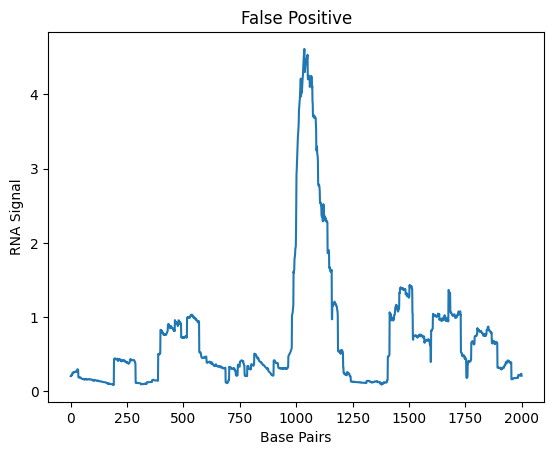

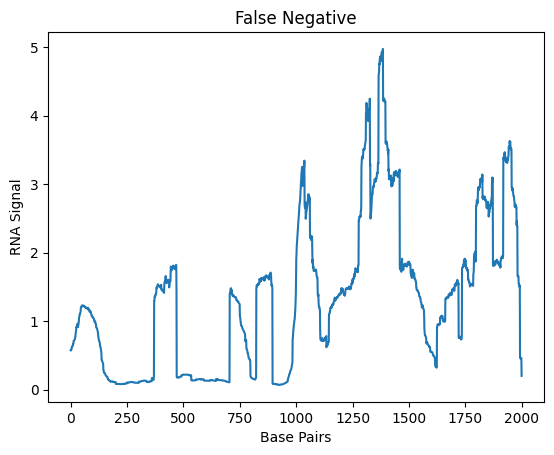

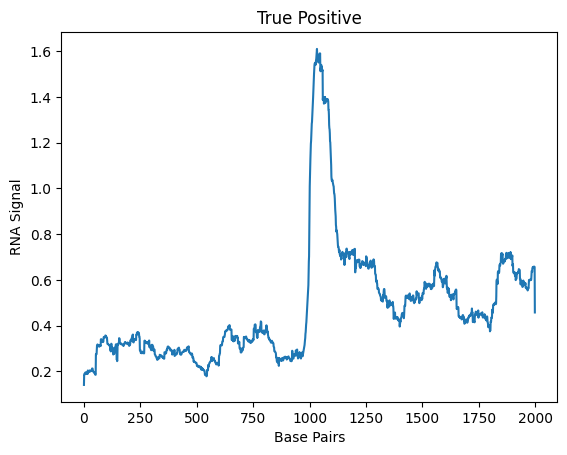

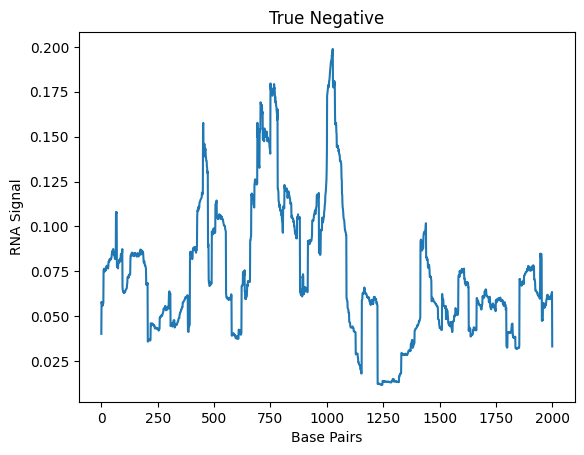

In [242]:
dfs = {"False Positive": fp, 
       "False Negative": fn, 
       "True Positive": tp, 
       "True Negative": tn}
h5s = [gm_h5, k5_h5]
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in gm_h5["ensid"]]
    rna = gm_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
    plt.show()

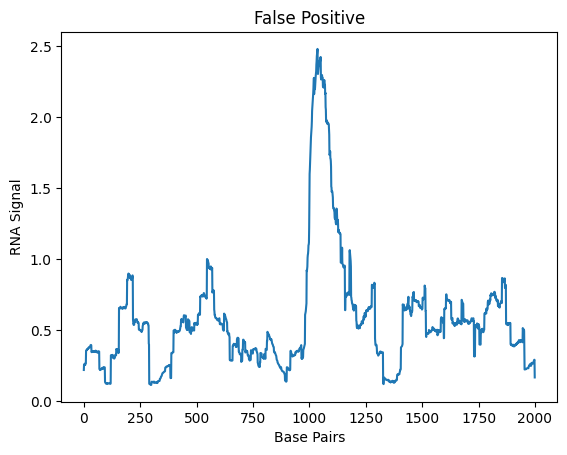

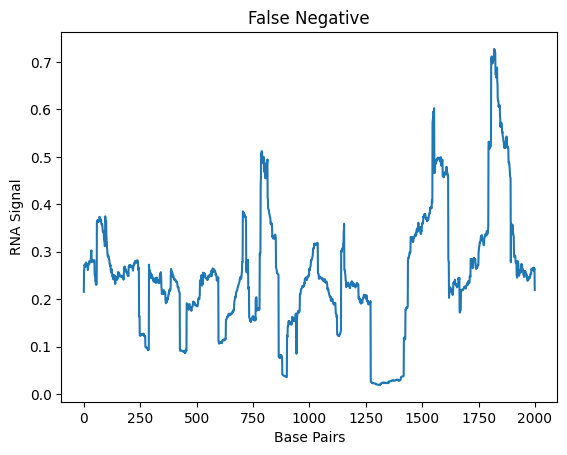

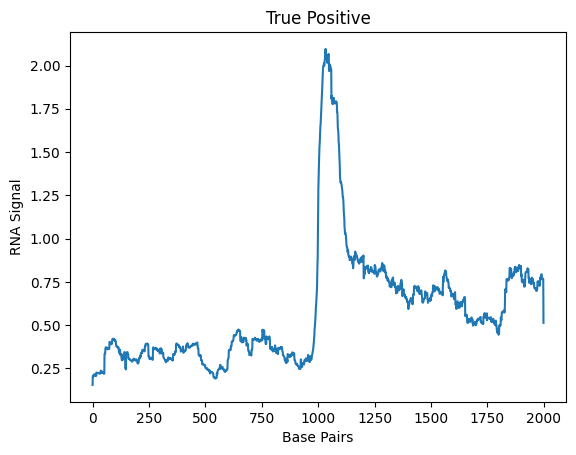

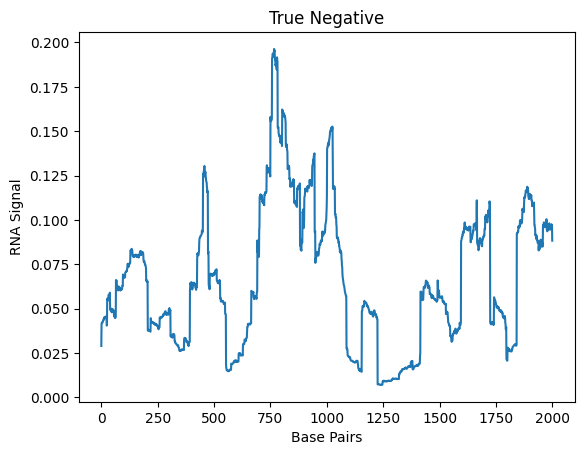

In [ ]:
# dfs = {"False Positive": fp, 
#        "False Negative": fn, 
#        "True Positive": tp, 
#        "True Negative": tn}
# h5s = [gm_h5, k5_h5]
# for title, df in dfs.items():
#     bool_df = [gene.decode() in list(df["ENSID"]) for gene in gm_h5["ensid"]]
#     rna = gm_h5["rna"][:][bool_df]
#     plt.plot(np.mean(rna, axis=0))
#     plt.xlabel("Base Pairs")
#     plt.ylabel("RNA Signal")
#     plt.title(title)
#     plt.show()